In [1]:
# imports

import os
import tempfile
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn as sk
import tensorflow as tf
import tensorflow_datasets as tfds
from IPython.display import clear_output
from matplotlib import pyplot as plt

from sklearn import model_selection as skms
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers
from tensorflow.keras import regularizers


# display options for pandas and numpy
pd.set_option('display.max_rows', None, 'display.max_columns', None)
np.set_printoptions(threshold=np.inf)

# cycle colors for matplotlib
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# # Initialize TPUs for google colab
# resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
# tf.config.experimental_connect_to_cluster(resolver)
# # This is the TPU initialization code that has to be at the beginning.
# tf.tpu.experimental.initialize_tpu_system(resolver)
# print("All devices: ", tf.config.list_logical_devices('TPU'))

# tf.compat.v1.disable_v2_behavior()
# tf.compat.v1.disable_eager_execution()

print("Tensorflow version ", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Tensorflow version  2.10.0
Num GPUs Available:  1


# This notebook creates a model for training a keras model on tracklet data from the MPC

globals

In [2]:
# globals

ACTIVATION = 'relu'
TOTAL_SAMPLES = 5997886
SUB_SAMPLE_SIZE = 100000
TRAINING_SIZE = SUB_SAMPLE_SIZE * 0.9
PATIENCE = 10

METRICS = [tf.keras.metrics.TruePositives(name='tp'),
           tf.keras.metrics.FalsePositives(name='fp'),
           tf.keras.metrics.TrueNegatives(name='tn'),
           tf.keras.metrics.FalseNegatives(name='fn'),
           tf.keras.metrics.BinaryAccuracy(name='accuracy'),
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall'),
           tf.keras.metrics.AUC(name='auc'),
           tf.keras.metrics.AUC(name='prc', curve='PR')]  # precision-recall curve

Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



2022-12-05 23:27:28.557525: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-05 23:27:28.557655: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


filepaths

In [3]:
# filepaths
parent_dir = os.path.dirname(os.getcwd())
code_dir = os.path.join(parent_dir, 'neo_classifier')
data_dir = os.path.join(parent_dir, 'data')

headers

In [4]:
# headers
# all raw data from .trk files.
header_all = ['NEO',
              'objectID',
              'trkID',
              'JDUTC_0',
              'X_0',
              'Y_0',
              'Z_0',
              'M_0',
              'sigmaJDUTC_0',
              'sigmaX_0',
              'sigmaY_0',
              'sigmaZ_0',
              'sigmaM_0',
              'solar_ang_0',
              'lunar_ang_0',
              'jovian_ang_0',
              'JDUTC_1',
              'X_1',
              'Y_1',
              'Z_1',
              'M_1',
              'sigmaJDUTC_1',
              'sigmaX_1',
              'sigmaY_1',
              'sigmaZ_1',
              'sigmaM_1',
              'solar_ang_1',
              'lunar_ang_1',
              'jovian_ang_1',
              'JDUTC_2',
              'X_2',
              'Y_2',
              'Z_2',
              'M_2',
              'sigmaJDUTC_2',
              'sigmaX_2',
              'sigmaY_2',
              'sigmaZ_2',
              'sigmaM_2',
              'solar_ang_2',
              'lunar_ang_2',
              'jovian_ang_2',
              'JDUTC_3',
              'X_3',
              'Y_3',
              'Z_3',
              'M_3',
              'sigmaJDUTC_3',
              'sigmaX_3',
              'sigmaY_3',
              'sigmaZ_3',
              'sigmaM_3',
              'solar_ang_3',
              'lunar_ang_3',
              'jovian_ang_3',
              'JDUTC_4',
              'X_4',
              'Y_4',
              'Z_4',
              'M_4',
              'sigmaJDUTC_4',
              'sigmaX_4',
              'sigmaY_4',
              'sigmaZ_4',
              'sigmaM_4',
              'solar_ang_4',
              'lunar_ang_4',
              'jovian_ang_4',
              'JDUTC_5',
              'X_5',
              'Y_5',
              'Z_5',
              'M_5',
              'sigmaJDUTC_5',
              'sigmaX_5',
              'sigmaY_5',
              'sigmaZ_5',
              'sigmaM_5',
              'solar_ang_5',
              'lunar_ang_5',
              'jovian_ang_5',
              'JDUTC_6',
              'X_6',
              'Y_6',
              'Z_6',
              'M_6',
              'sigmaJDUTC_6',
              'sigmaX_6',
              'sigmaY_6',
              'sigmaZ_6',
              'sigmaM_6',
              'solar_ang_6',
              'lunar_ang_6',
              'jovian_ang_6',
              'JDUTC_7',
              'X_7',
              'Y_7',
              'Z_7',
              'M_7',
              'sigmaJDUTC_7',
              'sigmaX_7',
              'sigmaY_7',
              'sigmaZ_7',
              'sigmaM_7',
              'solar_ang_7',
              'lunar_ang_7',
              'jovian_ang_7',
              'JDUTC_8',
              'X_8',
              'Y_8',
              'Z_8',
              'M_8',
              'sigmaJDUTC_8',
              'sigmaX_8',
              'sigmaY_8',
              'sigmaZ_8',
              'sigmaM_8',
              'solar_ang_8',
              'lunar_ang_8',
              'jovian_ang_8',
              'JDUTC_9',
              'X_9',
              'Y_9',
              'Z_9',
              'M_9',
              'sigmaJDUTC_9',
              'sigmaX_9',
              'sigmaY_9',
              'sigmaZ_9',
              'sigmaM_9',
              'solar_ang_9',
              'lunar_ang_9',
              'jovian_ang_9',
              'mu_ra_0',
              'mu_dec_0',
              'mu_sq_0',
              'mu_ra_1',
              'mu_dec_1',
              'mu_sq_1',
              'mu_ra_2',
              'mu_dec_2',
              'mu_sq_2',
              'mu_ra_3',
              'mu_dec_3',
              'mu_sq_3',
              'mu_ra_4',
              'mu_dec_4',
              'mu_sq_4',
              'mu_ra_5',
              'mu_dec_5',
              'mu_sq_5',
              'mu_ra_6',
              'mu_dec_6',
              'mu_sq_6',
              'mu_ra_7',
              'mu_dec_7',
              'mu_sq_7',
              'mu_ra_8',
              'mu_dec_8',
              'mu_sq_8',
              'd2_NEO_ALL',
              'd2_NEO_NEW']

# removed headers starting with sigma as they are all zeros
header_minus_sigma = ['NEO',
                      'objectID',
                      'trkID',
                      'JDUTC_0',
                      'X_0',
                      'Y_0',
                      'Z_0',
                      'M_0',
                      'solar_ang_0',
                      'lunar_ang_0',
                      'jovian_ang_0',
                      'JDUTC_1',
                      'X_1',
                      'Y_1',
                      'Z_1',
                      'M_1',
                      'solar_ang_1',
                      'lunar_ang_1',
                      'jovian_ang_1',
                      'JDUTC_2',
                      'X_2',
                      'Y_2',
                      'Z_2',
                      'M_2',
                      'solar_ang_2',
                      'lunar_ang_2',
                      'jovian_ang_2',
                      'JDUTC_3',
                      'X_3',
                      'Y_3',
                      'Z_3',
                      'M_3',
                      'solar_ang_3',
                      'lunar_ang_3',
                      'jovian_ang_3',
                      'JDUTC_4',
                      'X_4',
                      'Y_4',
                      'Z_4',
                      'M_4',
                      'solar_ang_4',
                      'lunar_ang_4',
                      'jovian_ang_4',
                      'JDUTC_5',
                      'X_5',
                      'Y_5',
                      'Z_5',
                      'M_5',
                      'solar_ang_5',
                      'lunar_ang_5',
                      'jovian_ang_5',
                      'JDUTC_6',
                      'X_6',
                      'Y_6',
                      'Z_6',
                      'M_6',
                      'solar_ang_6',
                      'lunar_ang_6',
                      'jovian_ang_6',
                      'JDUTC_7',
                      'X_7',
                      'Y_7',
                      'Z_7',
                      'M_7',
                      'solar_ang_7',
                      'lunar_ang_7',
                      'jovian_ang_7',
                      'JDUTC_8',
                      'X_8',
                      'Y_8',
                      'Z_8',
                      'M_8',
                      'solar_ang_8',
                      'lunar_ang_8',
                      'jovian_ang_8',
                      'JDUTC_9',
                      'X_9',
                      'Y_9',
                      'Z_9',
                      'M_9',
                      'solar_ang_9',
                      'lunar_ang_9',
                      'jovian_ang_9',
                      'mu_ra_0',
                      'mu_dec_0',
                      'mu_sq_0',
                      'mu_ra_1',
                      'mu_dec_1',
                      'mu_sq_1',
                      'mu_ra_2',
                      'mu_dec_2',
                      'mu_sq_2',
                      'mu_ra_3',
                      'mu_dec_3',
                      'mu_sq_3',
                      'mu_ra_4',
                      'mu_dec_4',
                      'mu_sq_4',
                      'mu_ra_5',
                      'mu_dec_5',
                      'mu_sq_5',
                      'mu_ra_6',
                      'mu_dec_6',
                      'mu_sq_6',
                      'mu_ra_7',
                      'mu_dec_7',
                      'mu_sq_7',
                      'mu_ra_8',
                      'mu_dec_8',
                      'mu_sq_8',
                      'd2_NEO_ALL',
                      'd2_NEO_NEW']

# removed last two features d2_NEO_ALL and d2_NEO_NEW
header_objID = ['NEO',
                'objectID',
                'trkID',
                'JDUTC_0',
                'X_0',
                'Y_0',
                'Z_0',
                'M_0',
                'solar_ang_0',
                'lunar_ang_0',
                'jovian_ang_0',
                'JDUTC_1',
                'X_1',
                'Y_1',
                'Z_1',
                'M_1',
                'solar_ang_1',
                'lunar_ang_1',
                'jovian_ang_1',
                'JDUTC_2',
                'X_2',
                'Y_2',
                'Z_2',
                'M_2',
                'solar_ang_2',
                'lunar_ang_2',
                'jovian_ang_2',
                'JDUTC_3',
                'X_3',
                'Y_3',
                'Z_3',
                'M_3',
                'solar_ang_3',
                'lunar_ang_3',
                'jovian_ang_3',
                'JDUTC_4',
                'X_4',
                'Y_4',
                'Z_4',
                'M_4',
                'solar_ang_4',
                'lunar_ang_4',
                'jovian_ang_4',
                'JDUTC_5',
                'X_5',
                'Y_5',
                'Z_5',
                'M_5',
                'solar_ang_5',
                'lunar_ang_5',
                'jovian_ang_5',
                'JDUTC_6',
                'X_6',
                'Y_6',
                'Z_6',
                'M_6',
                'solar_ang_6',
                'lunar_ang_6',
                'jovian_ang_6',
                'JDUTC_7',
                'X_7',
                'Y_7',
                'Z_7',
                'M_7',
                'solar_ang_7',
                'lunar_ang_7',
                'jovian_ang_7',
                'JDUTC_8',
                'X_8',
                'Y_8',
                'Z_8',
                'M_8',
                'solar_ang_8',
                'lunar_ang_8',
                'jovian_ang_8',
                'JDUTC_9',
                'X_9',
                'Y_9',
                'Z_9',
                'M_9',
                'solar_ang_9',
                'lunar_ang_9',
                'jovian_ang_9',
                'mu_ra_0',
                'mu_dec_0',
                'mu_sq_0',
                'mu_ra_1',
                'mu_dec_1',
                'mu_sq_1',
                'mu_ra_2',
                'mu_dec_2',
                'mu_sq_2',
                'mu_ra_3',
                'mu_dec_3',
                'mu_sq_3',
                'mu_ra_4',
                'mu_dec_4',
                'mu_sq_4',
                'mu_ra_5',
                'mu_dec_5',
                'mu_sq_5',
                'mu_ra_6',
                'mu_dec_6',
                'mu_sq_6',
                'mu_ra_7',
                'mu_dec_7',
                'mu_sq_7',
                'mu_ra_8',
                'mu_dec_8',
                'mu_sq_8']

# removed objectID and trkID features only remaining features are labels and numeric columns for training
header_numeric_features = tfds.features.FeaturesDict({'NEO': tf.float32,
                                                      'JDUTC_0': tf.float32,
                                                      'X_0': tf.float32,
                                                      'Y_0': tf.float32,
                                                      'Z_0': tf.float32,
                                                      'M_0': tf.float32,
                                                      'JDUTC_1': tf.float32,
                                                      'X_1': tf.float32,
                                                      'Y_1': tf.float32,
                                                      'Z_1': tf.float32,
                                                      'M_1': tf.float32,
                                                      'JDUTC_2': tf.float32,
                                                      'X_2': tf.float32,
                                                      'Y_2': tf.float32,
                                                      'Z_2': tf.float32,
                                                      'M_2': tf.float32,
                                                      'JDUTC_3': tf.float32,
                                                      'X_3': tf.float32,
                                                      'Y_3': tf.float32,
                                                      'Z_3': tf.float32,
                                                      'M_3': tf.float32,
                                                      'JDUTC_4': tf.float32,
                                                      'X_4': tf.float32,
                                                      'Y_4': tf.float32,
                                                      'Z_4': tf.float32,
                                                      'M_4': tf.float32,
                                                      'JDUTC_5': tf.float32,
                                                      'X_5': tf.float32,
                                                      'Y_5': tf.float32,
                                                      'Z_5': tf.float32,
                                                      'M_5': tf.float32,
                                                      'JDUTC_6': tf.float32,
                                                      'X_6': tf.float32,
                                                      'Y_6': tf.float32,
                                                      'Z_6': tf.float32,
                                                      'M_6': tf.float32,
                                                      'JDUTC_7': tf.float32,
                                                      'X_7': tf.float32,
                                                      'Y_7': tf.float32,
                                                      'Z_7': tf.float32,
                                                      'M_7': tf.float32,
                                                      'JDUTC_8': tf.float32,
                                                      'X_8': tf.float32,
                                                      'Y_8': tf.float32,
                                                      'Z_8': tf.float32,
                                                      'M_8': tf.float32,
                                                      'JDUTC_9': tf.float32,
                                                      'X_9': tf.float32,
                                                      'Y_9': tf.float32,
                                                      'Z_9': tf.float32,
                                                      'M_9': tf.float32,
                                                      'mu_ra_0': tf.float32,
                                                      'mu_dec_0': tf.float32,
                                                      'mu_sq_0': tf.float32,
                                                      'mu_ra_1': tf.float32,
                                                      'mu_dec_1': tf.float32,
                                                      'mu_sq_1': tf.float32,
                                                      'mu_ra_2': tf.float32,
                                                      'mu_dec_2': tf.float32,
                                                      'mu_sq_2': tf.float32,
                                                      'mu_ra_3': tf.float32,
                                                      'mu_dec_3': tf.float32,
                                                      'mu_sq_3': tf.float32,
                                                      'mu_ra_4': tf.float32,
                                                      'mu_dec_4': tf.float32,
                                                      'mu_sq_4': tf.float32,
                                                      'mu_ra_5': tf.float32,
                                                      'mu_dec_5': tf.float32,
                                                      'mu_sq_5': tf.float32,
                                                      'mu_ra_6': tf.float32,
                                                      'mu_dec_6': tf.float32,
                                                      'mu_sq_6': tf.float32,
                                                      'mu_ra_7': tf.float32,
                                                      'mu_dec_7': tf.float32,
                                                      'mu_sq_7': tf.float32,
                                                      'mu_ra_8': tf.float32,
                                                      'mu_dec_8': tf.float32,
                                                      'mu_sq_8': tf.float32})

header_features = tfds.features.FeaturesDict({'JDUTC_0': tf.float32,
                                              'X_0': tf.float32,
                                              'Y_0': tf.float32,
                                              'Z_0': tf.float32,
                                              'M_0': tf.float32,
                                              'JDUTC_1': tf.float32,
                                              'X_1': tf.float32,
                                              'Y_1': tf.float32,
                                              'Z_1': tf.float32,
                                              'M_1': tf.float32,
                                              'JDUTC_2': tf.float32,
                                              'X_2': tf.float32,
                                              'Y_2': tf.float32,
                                              'Z_2': tf.float32,
                                              'M_2': tf.float32,
                                              'JDUTC_3': tf.float32,
                                              'X_3': tf.float32,
                                              'Y_3': tf.float32,
                                              'Z_3': tf.float32,
                                              'M_3': tf.float32,
                                              'JDUTC_4': tf.float32,
                                              'X_4': tf.float32,
                                              'Y_4': tf.float32,
                                              'Z_4': tf.float32,
                                              'M_4': tf.float32,
                                              'JDUTC_5': tf.float32,
                                              'X_5': tf.float32,
                                              'Y_5': tf.float32,
                                              'Z_5': tf.float32,
                                              'M_5': tf.float32,
                                              'JDUTC_6': tf.float32,
                                              'X_6': tf.float32,
                                              'Y_6': tf.float32,
                                              'Z_6': tf.float32,
                                              'M_6': tf.float32,
                                              'JDUTC_7': tf.float32,
                                              'X_7': tf.float32,
                                              'Y_7': tf.float32,
                                              'Z_7': tf.float32,
                                              'M_7': tf.float32,
                                              'JDUTC_8': tf.float32,
                                              'X_8': tf.float32,
                                              'Y_8': tf.float32,
                                              'Z_8': tf.float32,
                                              'M_8': tf.float32,
                                              'JDUTC_9': tf.float32,
                                              'X_9': tf.float32,
                                              'Y_9': tf.float32,
                                              'Z_9': tf.float32,
                                              'M_9': tf.float32,
                                              'mu_ra_0': tf.float32,
                                              'mu_dec_0': tf.float32,
                                              'mu_sq_0': tf.float32,
                                              'mu_ra_1': tf.float32,
                                              'mu_dec_1': tf.float32,
                                              'mu_sq_1': tf.float32,
                                              'mu_ra_2': tf.float32,
                                              'mu_dec_2': tf.float32,
                                              'mu_sq_2': tf.float32,
                                              'mu_ra_3': tf.float32,
                                              'mu_dec_3': tf.float32,
                                              'mu_sq_3': tf.float32,
                                              'mu_ra_4': tf.float32,
                                              'mu_dec_4': tf.float32,
                                              'mu_sq_4': tf.float32,
                                              'mu_ra_5': tf.float32,
                                              'mu_dec_5': tf.float32,
                                              'mu_sq_5': tf.float32,
                                              'mu_ra_6': tf.float32,
                                              'mu_dec_6': tf.float32,
                                              'mu_sq_6': tf.float32,
                                              'mu_ra_7': tf.float32,
                                              'mu_dec_7': tf.float32,
                                              'mu_sq_7': tf.float32,
                                              'mu_ra_8': tf.float32,
                                              'mu_dec_8': tf.float32,
                                              'mu_sq_8': tf.float32})

baseline_header = ['JDUTC_0',
                   'X_0',
                   'Y_0',
                   'Z_0',
                   'M_0',
                   'JDUTC_1',
                   'X_1',
                   'Y_1',
                   'Z_1',
                   'M_1',
                   'mu_ra_0',
                   'mu_dec_0',
                   'mu_sq_0']

baseline_header_NEO = ['NEO',
                       'JDUTC_0',
                       'X_0',
                       'Y_0',
                       'Z_0',
                       'M_0',
                       'JDUTC_1',
                       'X_1',
                       'Y_1',
                       'Z_1',
                       'M_1',
                       'mu_ra_0',
                       'mu_dec_0',
                       'mu_sq_0']

definitions

In [5]:
# functions used in this file

def load_trk(path):
    '''
    load tracklet data
    '''
    print("Loading tracklet files...")
    df_data = pd.read_csv(path)
    df_data.columns = df_data.columns.str.replace(' ', '')
    return df_data


def process_tracklet(df_neo, df_nonneo):
    '''
    Adds a NEO column to the tracklet file to denote weather the tracklet is a 
    1 = NEO or 0 = Non-NEO. Reduce the two dataframes to only the features we 
    want then concatenate
    '''
    print('Processing tracklet files...')
    df_neo.insert(0, 'NEO', 1)
    df_nonneo.insert(0, 'NEO', 0)

    df_all = pd.concat([df_neo[header.header_numeric_features],
                        df_nonneo[header.header_numeric_features]],
                       ignore_index=True)

    return df_all


def save_tracklet_features():
    '''
    First we load data from tracklet standardizer.  The data is saved 
    seperately in NEO and NON-NEO files. We add a column to 
    differentiate between the two datasets, concatenate them and save
    them as a numpy npy file for faster loading. We usually don't 
    have to do this unless there is new data from the MPC.
    '''
    # define filepaths
    neo_path = os.path.join(directory.data_dir, "NEO.trk")
    nonneo_path = os.path.join(directory.data_dir, "NONNEO.trk")
    npy_path = os.path.join(directory.data_dir, 'allneo.npy')
    csv_path = os.path.join(directory.data_dir, 'allneo.csv')

    # load data
    df_neo = load_trk(neo_path)
    df_nonneo = load_trk(nonneo_path)

    # process
    df_all = process_tracklet(df_neo, df_nonneo)

    # save as npy
    print('Saving tracklets as an .npy file...')
    np.save(npy_path, df_all)

    # save as csv to use in Top Cat
    print('Saving tracklets as an .csv file...')
    df_all.to_csv(csv_path, index=False)

    print('Completed.')


def shift_values_left(df):
    '''
    Finds zeros in a dataframe and sorts each row so that data is moved to the
    left and zeros are turned into NaNs and moved to the end of each row.  We
    choose to slice the dataframe at column 11 because each tracklet must have
    at least two observations.  We create a bitmask for elements equal to zero
    and mergesort the Trues and Falses while keeping their relative order. i 
    is an array of indicies foreach elements new position.  Values are 
    shifted according to the array i and copied back to the original dataframe.
    https://stackoverflow.com/questions/66733075/efficiently-remove-all-zeroes-from-pandas-dataframe

    '''
    s = df.iloc[:, 11:]
    i = np.argsort(s.eq(0.0), axis=1, kind='mergesort')
    df.iloc[:, 11:] = np.take_along_axis(s[s.ne(0.0)].values, i.values, axis=1)

    return df


def create_ragged_tf(df):
    '''
    Creates a ragged tensor of tracklets and their observations.  We take a
    padded array, remove the zeros and shift all values left.  Changed the
    array to a nested list and iterate through each list while filtering out
    the NaNs.  Returns a ragged tensor with each row containing a tracklet
    of differing lengths.
    https://stackoverflow.com/questions/70982172/remove-all-nan-from-nested-list
    '''
    x = shift_values_left(df)
    y = (x.to_numpy()).tolist()
    ragged_tf = [list(filter(lambda x: x == x, inner_list))
                 for inner_list in y]

    return ragged_tf


def find_imbalance(df_original, df_sample, deviation):
    '''
    Checks that the ratio of NEOs and Non-NEOs between the two datasets, 
    original and sample, are within the specified deviation.
    '''
    pct_dev = deviation * 100.0

    imbalance = df_original.value_counts('NEO', normalize=True)

    sample_imbalance = df_sample.value_counts('NEO', normalize=True)

    neo_high = imbalance[1] + (imbalance[1] * deviation)
    neo_low = imbalance[1] - (imbalance[1] * deviation)
    sample_neo = sample_imbalance[1]

    nonneo_high = imbalance[0] + (imbalance[0] * deviation)
    nonneo_low = imbalance[0] - (imbalance[0] * deviation)
    sample_nonneo = sample_imbalance[0]

    if (neo_low <= sample_neo <= neo_high) and (nonneo_low <= sample_nonneo <= nonneo_high):
        # print('Relative Frequency\n', end="")
        # print('NEOs:           ', end="")
        # print('%.2f' % (imbalance[1]*100), '%')
        # print('Non-NEOs:       ', end="")
        # print('%.2f' % (imbalance[0]*100), '%\n')

        # print('Sample data should be within %.2f' % pct_dev, '%')

        # print('neo_low:       %.4f' % (neo_low * 100), '%', end='        ')
        # print('nonneo_low:    %.4f' % (nonneo_low * 100), '%')
        # print('sample_neo     %.4f' %
        #       (sample_imbalance[1] * 100), '%', end='        ')
        # print('sample_nonneo: %.4f' % (sample_imbalance[0] * 100), '%')
        # print('neo_high:      %.4f' % (neo_high * 100), '%', end='        ')
        # print('nonneo_high:   %.4f' % (nonneo_high * 100), '%\n')

        return False  # if balance is good don't run again

    else:
        # print(f'Not within +/- {deviation * 100} %')
        return True  # if balance is bad run again


def sample_dataframe(df, pct, deviation):
    '''
    Samples the data set by pct and verifies that the sample has within
    0.05% of NEO and Non-NEO rows.
    '''
    b = True
    while b:
        df_sample = df.sample(frac=pct)
        b = find_imbalance(df, df_sample, deviation)

    return df_sample


def split_data(df_sample, train_val_size, deviation):
    '''
    Splits the data into training, validation and test sets.  sklearn's
    train_test_split function randomly samples the given array based on
    the fraction given data given.It also does not split into three
    subarrays so we choose a train/val size and split with test then 
    use the train/val data to split into training and validation. The
    validation set should be the same length as the test set.  We 
    then check for overlapping indicies and deviation. 
    '''
    b = np.full(6, False)

    while not b.all():
        train_val_test_split = skms.train_test_split(
            df_sample, train_size=train_val_size)
        train_val_split = skms.train_test_split(
            train_val_test_split[0], test_size=len(train_val_test_split[1]))

        df_test = train_val_test_split[1]
        df_train = train_val_split[0]
        df_val = train_val_split[1]

        b[0] = bool(list(set(df_train.index.values)
                    and set(df_test.index.values)))
        b[1] = bool(list(set(df_test.index.values)
                    and set(df_val.index.values)))
        b[2] = bool(list(set(df_val.index.values)
                    and set(df_train.index.values)))

        clear_output()

        # print("Testing training")
        b[3] = not find_imbalance(df_sample, df_train, deviation)
        # print('Testing Validation')
        b[4] = not find_imbalance(df_sample, df_val, deviation)
        # print('Testing Test')
        b[5] = not find_imbalance(df_sample, df_test, deviation)


    print(len(df_train), 'df_training examples')
    print(len(df_val), 'validation examples')
    print(len(df_test), 'df_test examples\n')
    # print(f'ran {i} times\n')

    df_test = pd.DataFrame(df_test).sort_index()
    df_train = pd.DataFrame(df_train).sort_index()
    df_val = pd.DataFrame(df_val).sort_index()

    return df_train, df_val, df_test


def create_features_labels(train, val, test):
    '''
    takes the data from our three sets and creates a normalized feature array.
    returns the features and the labels
    '''
    train_labels = np.array(train.pop('NEO'))
    val_labels = np.array(val.pop('NEO'))
    test_labels = np.array(test.pop('NEO'))
    bool_train_labels = train_labels != 0

    train.replace(0, np.nan, inplace=True)
    val.replace(0, np.nan, inplace=True)
    test.replace(0, np.nan, inplace=True)

    train_features = np.array(train)
    val_features = np.array(val)
    test_features = np.array(test)

    scaler = StandardScaler()
    train_features = pd.DataFrame(scaler.fit_transform(
        train_features), columns=baseline_header)
    val_features = pd.DataFrame(scaler.transform(
        val_features), columns=baseline_header)
    test_features = pd.DataFrame(scaler.transform(
        test_features), columns=baseline_header)

    train_features.replace(np.nan, 0, inplace=True)
    val_features.replace(np.nan, 0, inplace=True)
    test_features.replace(np.nan, 0, inplace=True)

    return train_features, val_features, test_features, [train_labels.astype(int), val_labels.astype(int), test_labels.astype(int)]


def baseline_dataset(df, labels):
    '''
    create a small dataset of only two tracklets for creating a baseline make_model 
    '''
    dataset = pd.DataFrame(df, columns=baseline_header)
    dataset['NEO'] = labels
    dataset.sample
    dataset = dataset.sample(frac=1).reset_index(drop=True)
    labels = dataset.pop('NEO')

    return dataset.to_numpy(), labels.to_numpy()





def quantify_prediction(prediction, labels, threshold):
    p = pd.DataFrame(prediction, columns=['Prediction'])
    p['Binary Pred'] = np.where(p['Prediction'] > threshold, 1, 0)
    p['Label'] = labels[:len(p)]
    p['Corr Pred'] = np.where(p['Binary Pred'] == p['Label'], 1, 0)
    counts = p['Corr Pred'].value_counts()

    print("\nPrediction Accuracy = ",
          (counts[1]/len(p['Corr Pred']))*100, "%\n")

    return p


def df_to_dataset(df, batch_size, shuffle, labels):
    '''
    creates a tensorflow dataset and optimizes it for training
    '''
    # df = {key: np.array(value)[:,tf.newaxis] for key, value in df.items()}
    ds = tf.data.Dataset.from_tensor_slices((df, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(df))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)

    return ds


def plot_metrics(history):
    metrics = ['loss', 'prc', 'precision', 'recall', 'auc', 'tp']
    for n, metric in enumerate(metrics):
        name = metric.replace("_", " ").capitalize()

        plt.subplot(3, 3, n+1)
        plt.plot(history.epoch,
                 history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_' + metric],
                 color=colors[1], linestyle="-", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        plt.grid(visible=True, axis='both')
        plt.legend()


def plot_cm(labels, predictions, cmap):
    cm = confusion_matrix(labels, predictions, normalize='true')
    sns.heatmap(cm.round(4)*100, annot=True, fmt="f",
                cmap=cmap, annot_kws={'fontsize': 'xx-large'})

    plt.title("Confusion matrix (%)")
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    ax = plt.gca()
    ax.set_aspect('equal')

    print(f'NEOs Found (True Positives): {cm[1][1]*100:.2f}%')
    print(f'NEOs Missed (False Negatives): {cm[1][0]*100:.2f}%')
    print(f'Non-NEOs Identified (True Negatives): {cm[0][0]*100:.2f}%')
    print(
        f'Non-NEOs Incorrectly Identified (False Positives): {cm[0][1]*100:.2f}%')

    print(f'Total NEOs: {np.sum(cm[1])}\n')


def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, thresholds = sk.metrics.roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    # plt.xlim([-0.5,20])
    # plt.ylim([80,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

    return fp, tp, thresholds


def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sk.metrics.precision_recall_curve(
        labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

tensorflow callbacks

In [6]:
# callbacks

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc',
    verbose=10,
    patience=PATIENCE,
    mode='max',
    restore_best_weights=True)


class SelectiveProgbarLogger(tf.keras.callbacks.ProgbarLogger):
    def __init__(self, verbose, epoch_interval, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.default_verbose = verbose
        self.epoch_interval = epoch_interval

    def on_epoch_begin(self, epoch, *args, **kwargs):
        self.verbose = (
            0
            if epoch % self.epoch_interval != 0
            else self.default_verbose
        )
        super().on_epoch_begin(epoch, *args, **kwargs)


CALLBACKS = [early_stopping]

### Data Pipeline

In [7]:
# create a dataset of features and labels to be passed into a model
percent_of_data = SUB_SAMPLE_SIZE/TOTAL_SAMPLES
split = TRAINING_SIZE/SUB_SAMPLE_SIZE
deviation = 0.005
batch_size_ds = pow(2, 15)

# process raw tracklet file
# dpl.save_tracklet_features()

# load data
npy_path = os.path.join(data_dir, 'allneo.npy')
df = pd.DataFrame(np.load(npy_path, allow_pickle=True),
                  columns=header_numeric_features)

df = pd.DataFrame(df[baseline_header_NEO], columns=baseline_header_NEO)
# df.head()

# subsample the data and divide into training, valiation and test sets
sample_df = sample_dataframe(df, percent_of_data, deviation)
train_df, val_df, test_df = split_data(sample_df, split, deviation)
train_df, val_df, test_df, labels = create_features_labels(
    train_df, val_df, test_df)

80000 df_training examples
10000 validation examples
10000 df_test examples



#### Data Exploration

In [8]:
# find the number of NEOs in the training and test datasets

print('Training')
vals, counts = np.unique(labels[0], return_counts=True)
neg, pos = counts[0], counts[1]
total = neg + pos
class_priors = [neg/total, pos/total]
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

print('Test')
val_vals, val_counts = np.unique(labels[2], return_counts=True)
val_neg, val_pos = val_counts[0], val_counts[1]
val_total = val_neg + val_pos
class_priors = [val_neg/val_total, val_pos/val_total]
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    val_total, val_pos, 100 * val_pos / val_total))

Training
Examples:
    Total: 80000
    Positive: 4049 (5.06% of total)

Validation
Examples:
    Total: 10000
    Positive: 507 (5.07% of total)



#### Baseline Model
Build the dataset


In [1]:
# batches should always include about the same amount of the positive class we have about 5.07% positive samples.
# the training sample should be divided into 20 parts with a batch size closest to a power of 2.
# for 1.5e6 samples we need to have batches of size 2^15

batch_size_ds = pow(2, 15)

# create baseline dataset with only 2 observations
train_bl, train_labels_bl = baseline_dataset(train_df, labels[0])
val_bl, val_labels_bl = baseline_dataset(val_df, labels[1])
test_bl, test_labels_bl = baseline_dataset(test_df, labels[2])

train_bl_ds = df_to_dataset(train_bl, batch_size_ds, True, train_labels_bl)
val_bl_ds = df_to_dataset(val_bl, batch_size_ds, False, val_labels_bl)
test_bl_ds = df_to_dataset(test_bl, batch_size_ds, False, test_labels_bl)

NameError: name 'baseline_dataset' is not defined

initial prediction

In [10]:
def baseline_model(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)

    model = tf.keras.Sequential([tf.keras.layers.Dense(8, activation=activation, input_shape=(13,)),
                              tf.keras.layers.Dense(4, activation=activation),
                              tf.keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=metrics)

    return model

    
activation = 'relu'
initial_bias = np.log([pos/neg])
batch_size_model = pow(2, 15)
threshold = 0.5
l2 = 0.00001

# create model

model = baseline_model(output_bias=initial_bias)

prediction = model.predict(train_bl, batch_size=batch_size_model, verbose=0)
p = quantify_prediction(prediction, train_labels_bl, threshold)
results = model.evaluate(train_bl, train_labels_bl,
                         batch_size=batch_size_model, verbose=0)

print(f'\npos/total = {pos/total}')
print("\nLoss: {:0.4f}\n".format(results[0]))

initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

epochs = 50

model = baseline_model()

initial_bias_history = model.fit(
    train_bl_ds,
    batch_size=batch_size_model,
    epochs=epochs,
    validation_data=val_bl_ds,
    verbose=0)

model = baseline_model()
model.load_weights(initial_weights)

prediction = model.predict(train_bl, batch_size=batch_size_model, verbose=0)
p = quantify_prediction(prediction, train_labels_bl, threshold)
results = model.evaluate(train_bl, train_labels_bl,
                         batch_size=batch_size_model, verbose=0)

print(f'\npos/total = {pos/total}')
print("\nLoss: {:0.4f}\n".format(results[0]))

baseline_history = model.fit(
    train_bl_ds,
    batch_size=batch_size_model,
    epochs=epochs,
    validation_data=val_bl_ds,
    verbose=0)

2022-12-05 23:27:32.391403: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-05 23:27:32.422502: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Prediction Accuracy =  94.93 %



2022-12-05 23:27:32.654670: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



pos/total = 0.0506125

Loss: 0.2088



2022-12-05 23:27:33.433076: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-05 23:27:34.260884: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-05 23:27:41.789417: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-05 23:27:41.973312: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Prediction Accuracy =  94.93 %


pos/total = 0.0506125

Loss: 0.2088



2022-12-05 23:27:42.623428: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-05 23:27:43.230719: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Plot the data to see if the initial bias helped

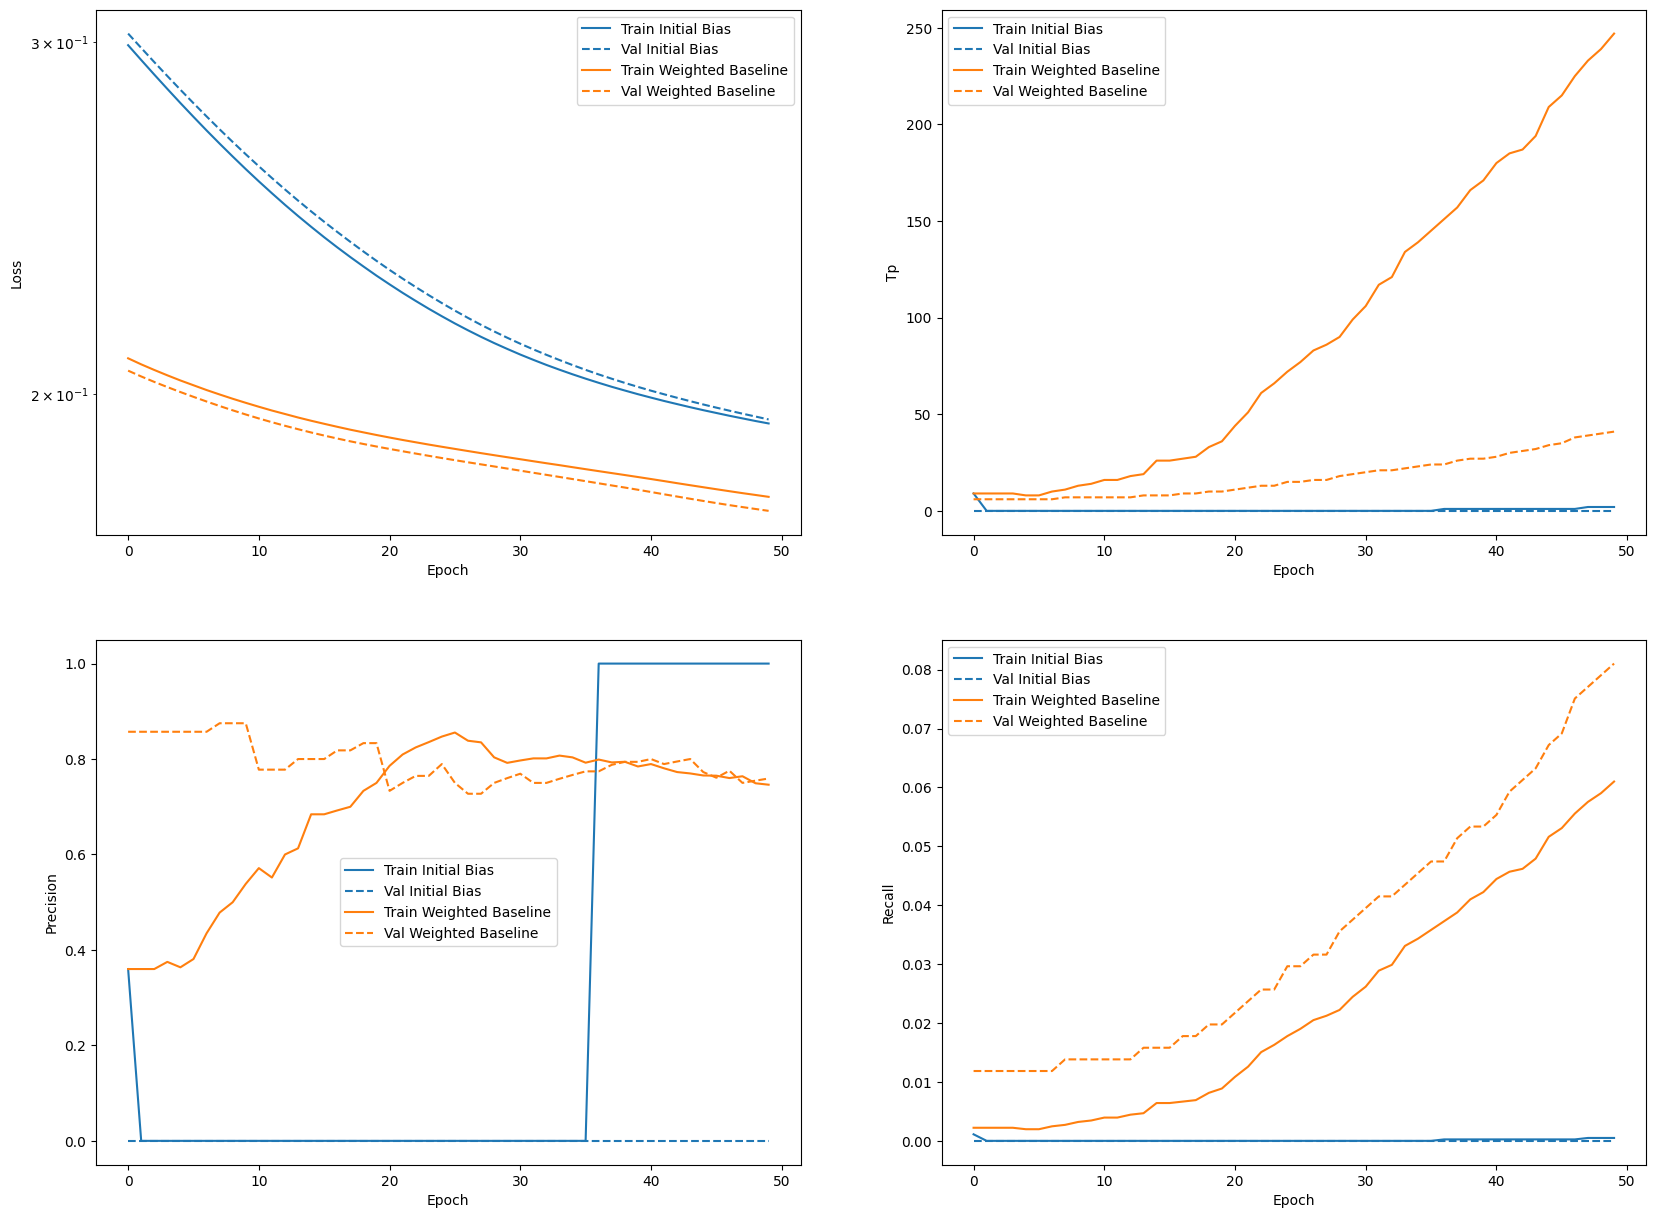

In [11]:
mpl.rcParams['figure.figsize'] = (20, 15)


def plot_loss(history, label, c):
    metrics = ['loss', 'tp', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_", " ").capitalize()

        plt.subplot(2, 2, n+1)

        if metric == 'loss':
            plt.semilogy(
                history.epoch, history.history[metric], color=colors[c], label='Train ' + label)
            plt.semilogy(history.epoch, history.history['val_' + metric],
                         color=colors[c], linestyle="--", label='Val ' + label)
            plt.xlabel('Epoch')
            plt.ylabel(name)
            plt.legend()

        else:
            plt.plot(
                history.epoch, history.history[metric], color=colors[c], label='Train ' + label)
            plt.plot(history.epoch, history.history['val_' + metric],
                     color=colors[c], linestyle="--", label='Val ' + label)
            plt.xlabel('Epoch')
            plt.ylabel(name)
            plt.legend()


# plot_loss(zero_bias_history, "Zero Bias", 0)

plot_loss(initial_bias_history, "Initial Bias", 0)
plot_loss(baseline_history, "Weighted Baseline", 1)

train the model

In [12]:
# batches should always include about the same amount of the positive class we have about 5.07% positive samples.
# the training sample should be divided into 20 parts with a batch size closest to a power of 2.
# for 1.5e6 samples we need to have batches of 2^15


epochs = 1000
batch_size_model = pow(2, 15)

model = baseline_model()
model.load_weights(initial_weights)

baseline_history = model.fit(
    train_bl_ds,
    batch_size=batch_size_model,
    epochs=epochs,
    validation_data=val_bl_ds,
    callbacks=CALLBACKS,
    verbose=0)

2022-12-05 23:27:53.798773: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-05 23:27:54.659987: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Restoring model weights from the end of the best epoch: 387.
Epoch 397: early stopping


plot the metrics


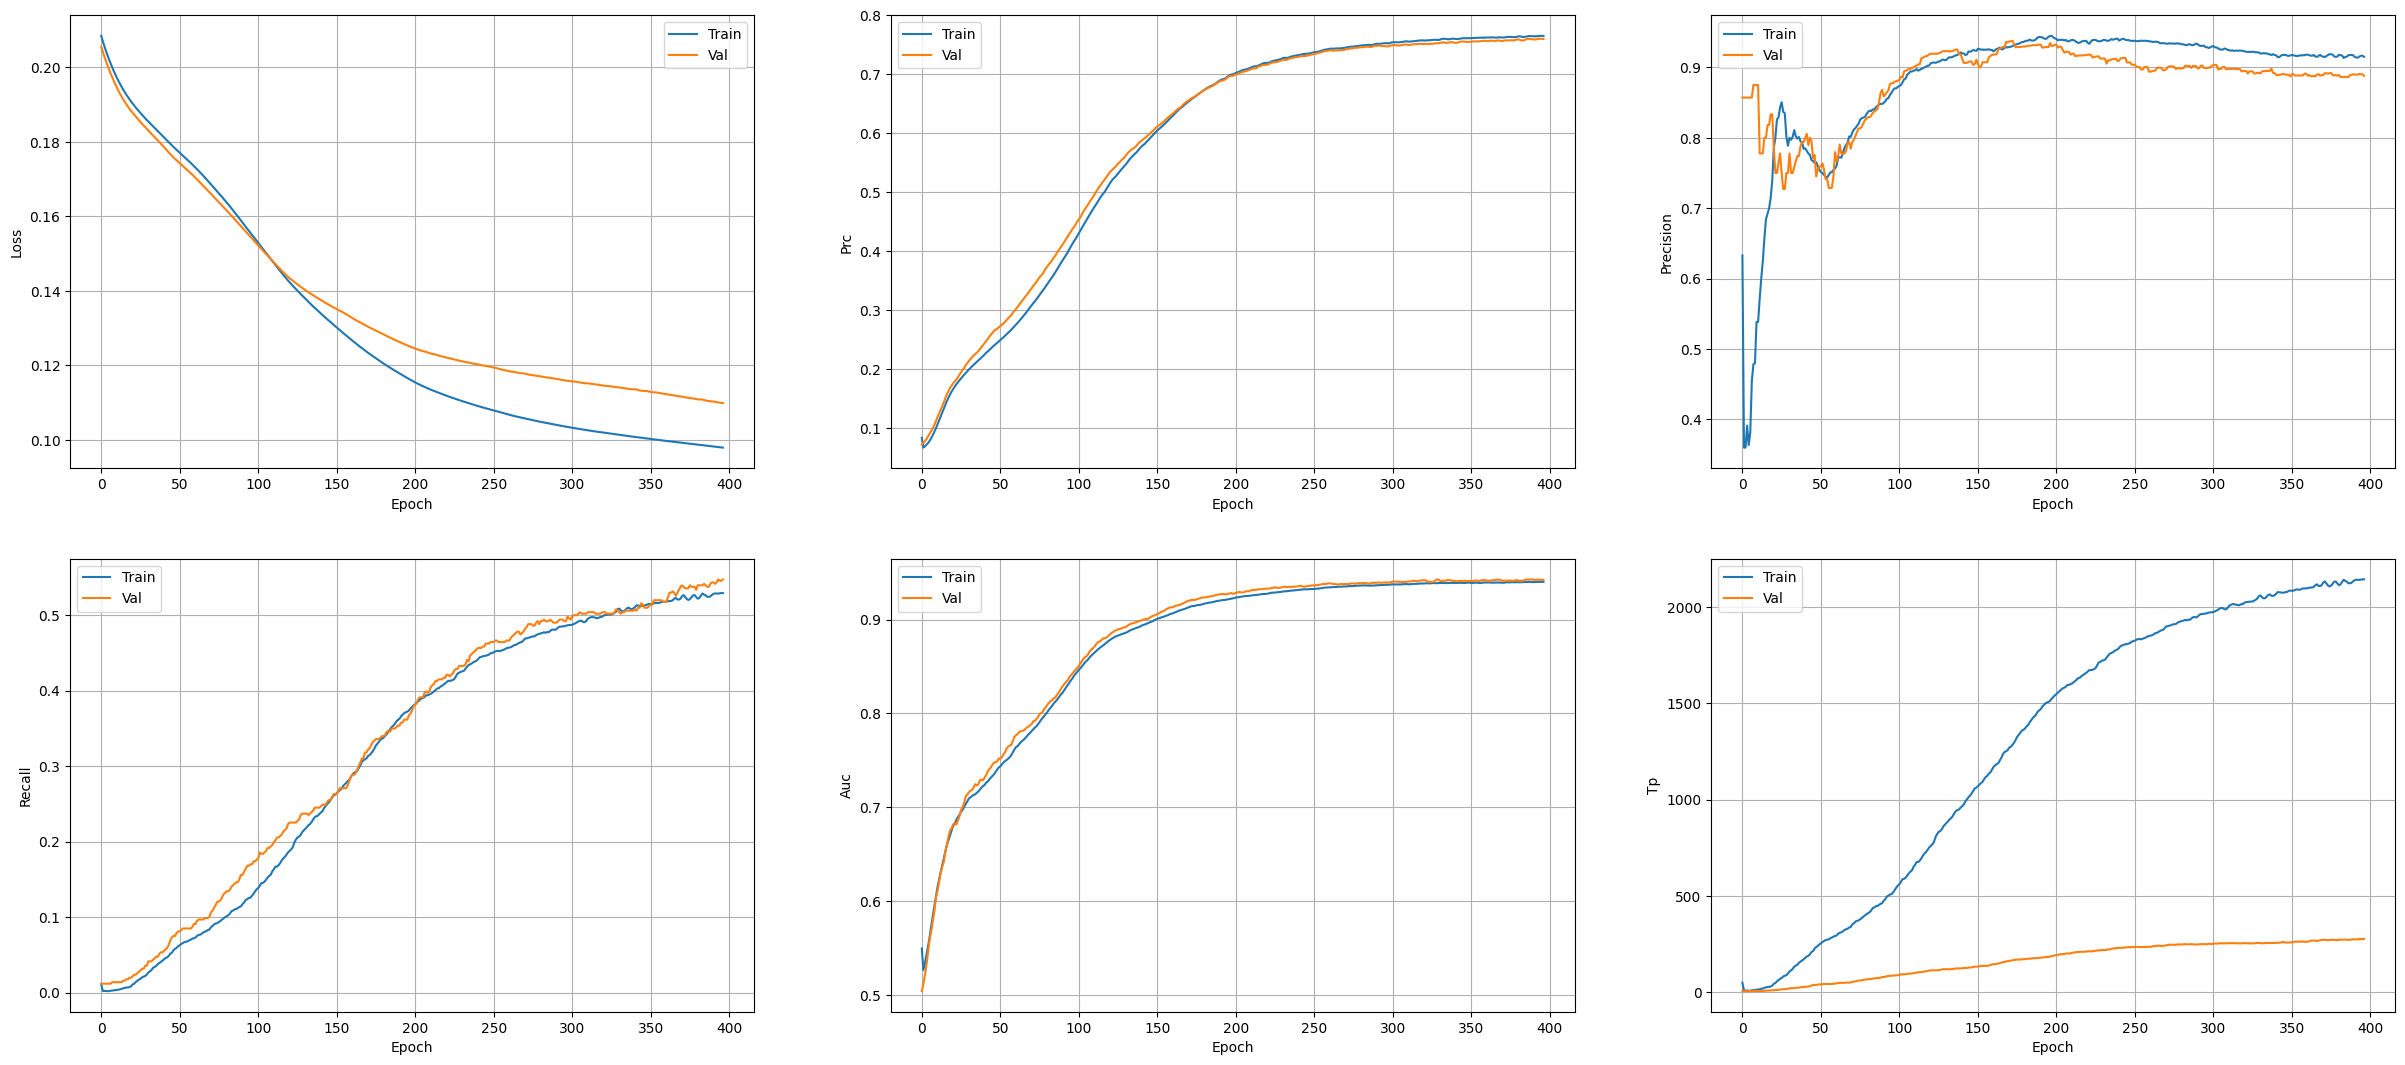

In [13]:
mpl.rcParams['figure.figsize'] = (30, 20)
plot_metrics(baseline_history)

find predictions and evalute on test

In [14]:
train_predictions_baseline = model.predict(train_bl_ds,
                                              batch_size=batch_size_model,
                                           verbose=1)

test_predictions_baseline = model.predict(test_bl_ds,
                                            batch_size=batch_size_model,
                                          verbose=1)

baseline_results = model.evaluate(test_bl_ds,
                                    batch_size=batch_size_model,
                                  verbose=1)

test_predictions_baseline_bool = np.where(test_predictions_baseline >= 0.5, 1, 0)

1/1 [==============================] - 0s 43ms/step - loss: 0.0964 - tp: 250.0000 - fp: 22.0000 - tn: 9471.0000 - fn: 257.0000 - accuracy: 0.9721 - precision: 0.9191 - recall: 0.4931 - auc: 0.9321 - prc: 0.7386


2022-12-05 23:29:08.321426: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Confusion Matrix, ROC and PRC for the test set

NEOs Found (True Positives): 49.31%
NEOs Missed (False Negatives): 50.69%
Non-NEOs Identified (True Negatives): 99.77%
Non-NEOs Incorrectly Identified (False Positives): 0.23%
Total NEOs: 1.0

loss : 0.10 

tp : 250.00 

fp : 22.00 

tn : 9471.00 

fn : 257.00 

accuracy : 0.97 

precision : 0.92 

recall : 0.49 

auc : 0.93 

prc : 0.74 



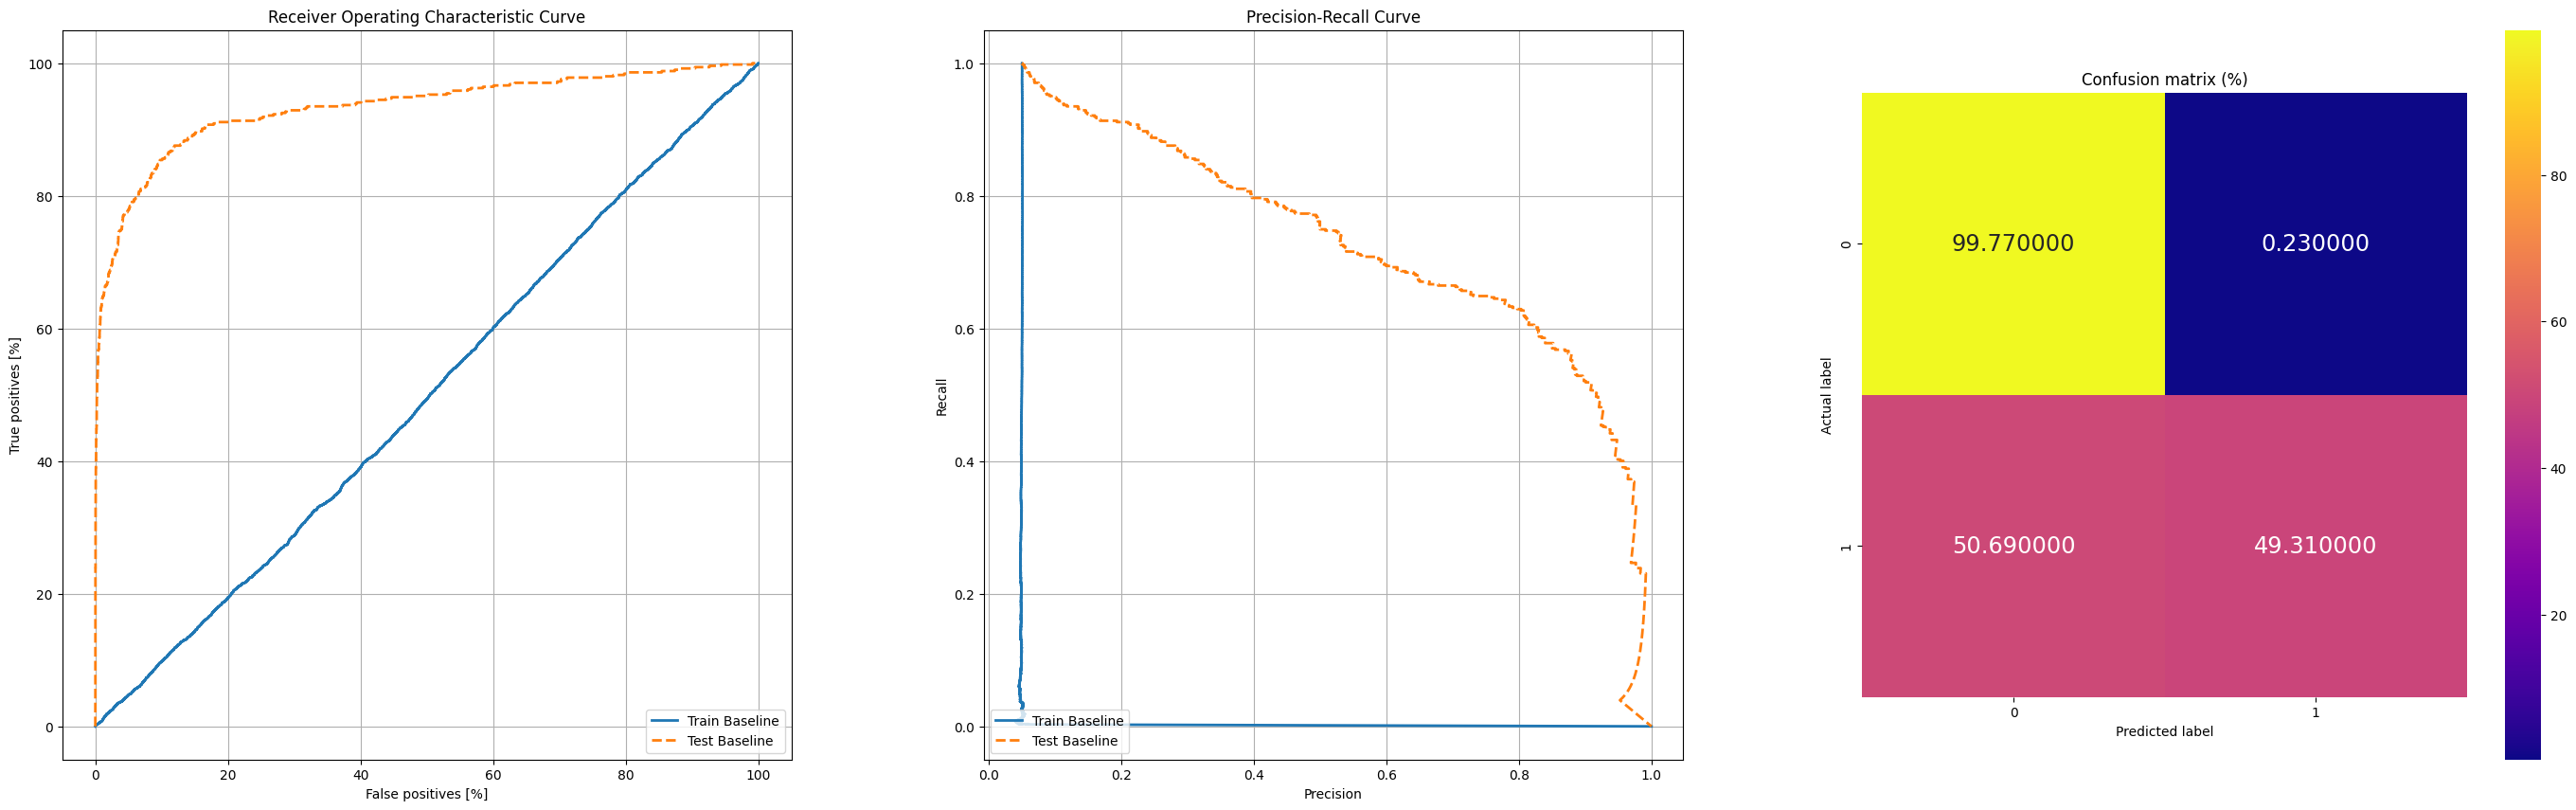

In [15]:
mpl.rcParams['figure.figsize'] = (35, 10)

plt.subplot(1, 3, 1)
plt.title('Receiver Operating Characteristic Curve')
train_fpr, train_tpr, train_roc_thresholds = plot_roc(
    "Train Baseline", train_labels_bl, train_predictions_baseline, color=colors[0])
test_fpr, test_tpr, test_roc_thresholds = plot_roc(
    "Test Baseline", test_labels_bl, test_predictions_baseline, color=colors[1], linestyle='--')
plt.legend(loc='lower right')

plt.subplot(1, 3, 2)
plt.title('Precision-Recall Curve')
plot_prc("Train Baseline", train_labels_bl,
         train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels_bl,
         test_predictions_baseline, color=colors[1], linestyle='--')
plt.legend(loc='lower left')

plt.subplot(1, 3, 3)
plot_cm(test_labels_bl, test_predictions_baseline_bool, 'plasma')

for name, value in zip(model.metrics_names, baseline_results):
    if name == 'tp':
        tp = value
    elif name == 'fp':
        fp = value
    elif name == 'tn':
        tn = value
    elif name == 'fn':
        fn = value

    print(f'{name} : {value:.2f} \n')

# cm = (confusion_matrix(test_labels_bl, test_predictions_baseline, normalize='true')*100)
# cm.round(2)

Add weigths to classes

In [16]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.

epochs = 1000
batch_size_model = pow(2, 15)

weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}\n\n'.format(weight_for_1))

weighted_model = baseline_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_bl_ds,
    batch_size=batch_size_model,
    epochs=epochs,
    validation_data=val_bl_ds,
    callbacks=CALLBACKS,
    verbose=0,
    class_weight=class_weight)

Weight for class 0: 0.53
Weight for class 1: 9.88




2022-12-05 23:29:09.303462: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-05 23:29:10.043732: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Restoring model weights from the end of the best epoch: 517.
Epoch 527: early stopping


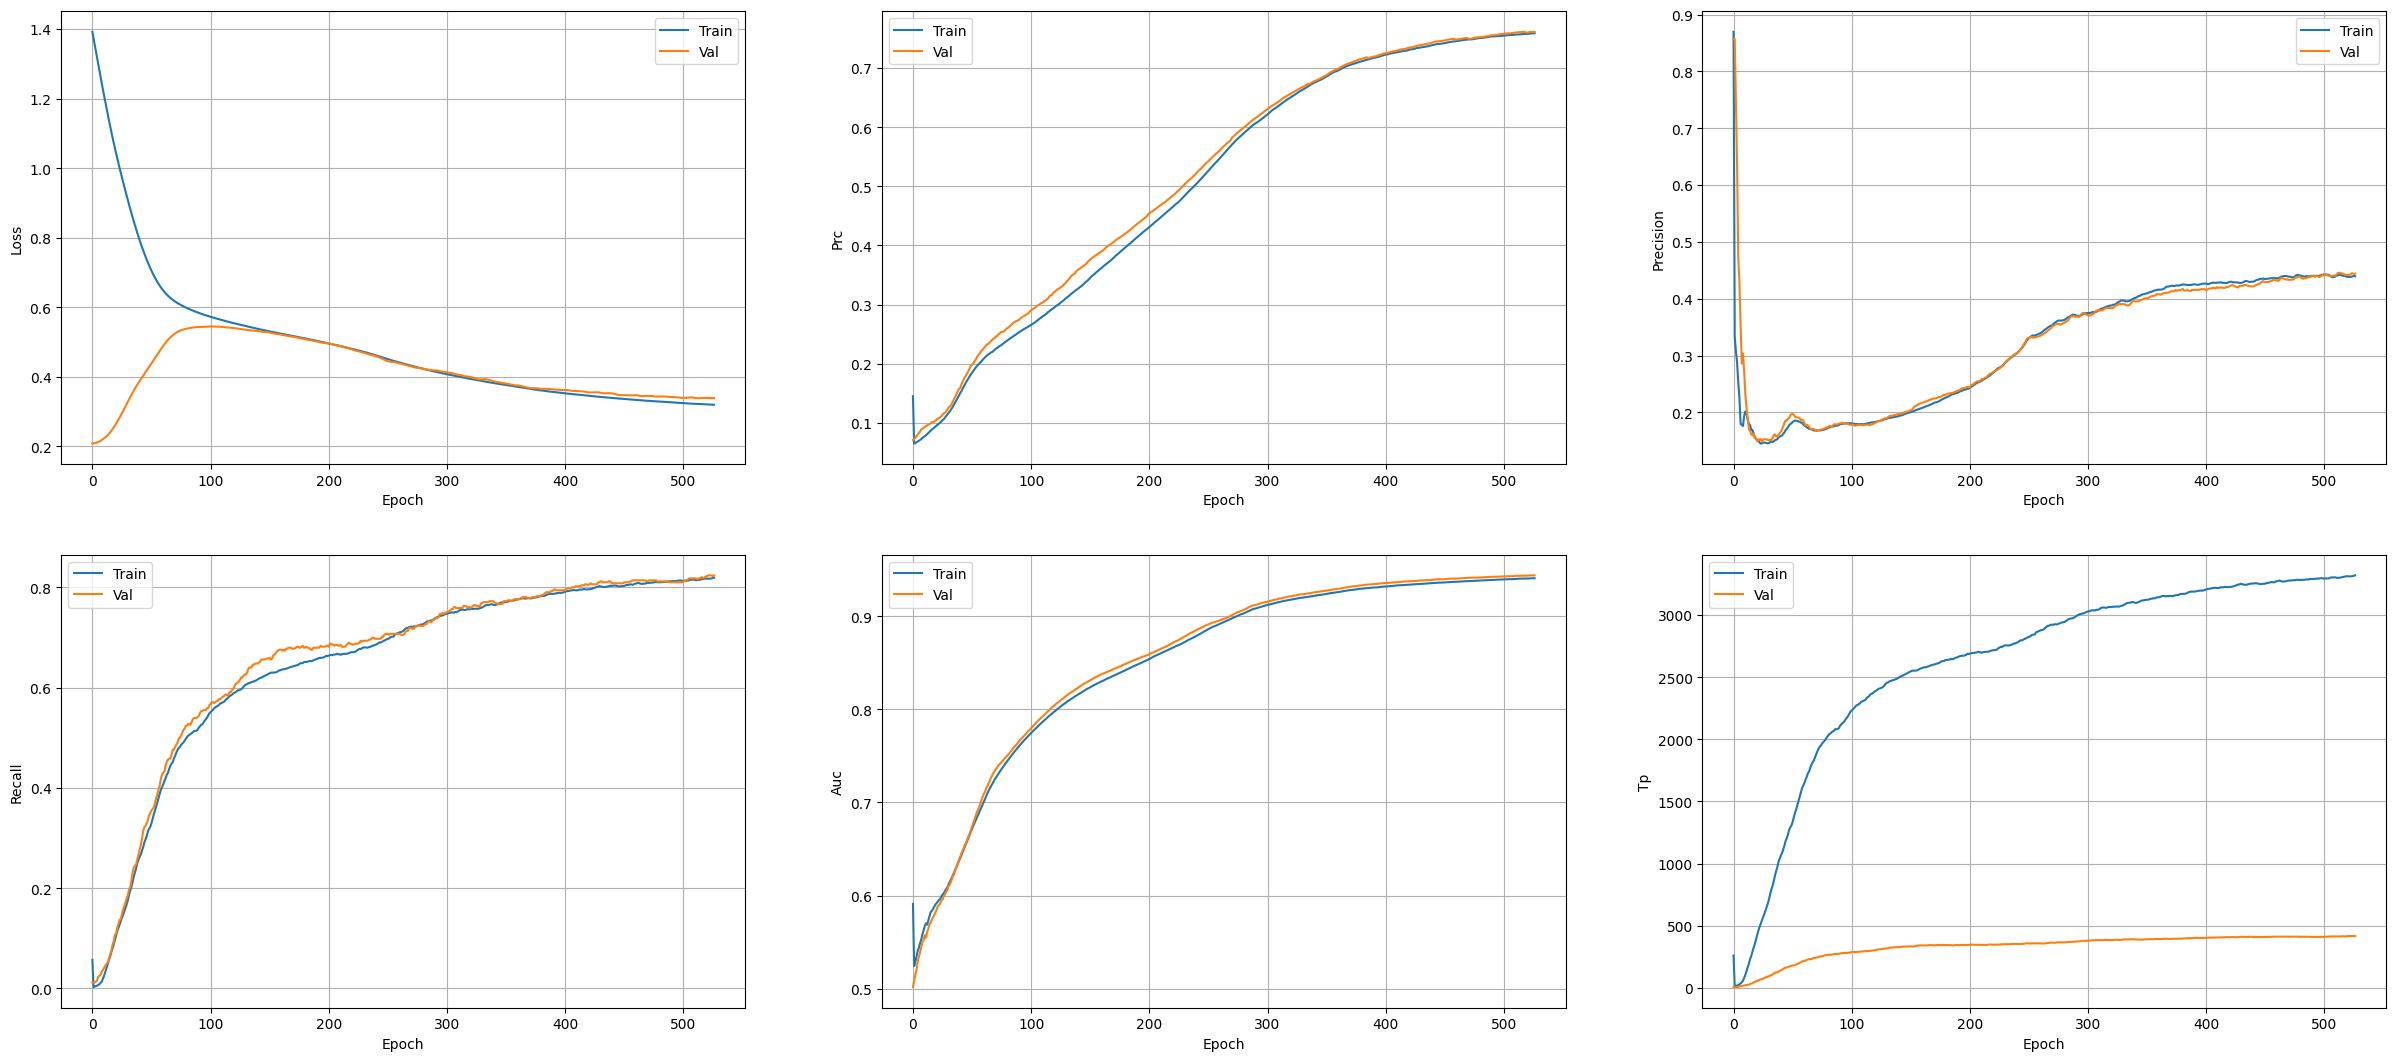

In [17]:
mpl.rcParams['figure.figsize'] = (30, 20)

plot_metrics(weighted_history)

In [18]:
train_predictions_weighted = weighted_model.predict(train_bl_ds,
                                                    batch_size=batch_size_model,
                                                    verbose=1)

test_predictions_weighted = weighted_model.predict(test_bl_ds,
                                                   batch_size=batch_size_model,
                                                   verbose=1)

weighted_results = weighted_model.evaluate(test_bl_ds,
                                           batch_size=batch_size_model,
                                           verbose=1)

test_predictions_weighted_bool = np.where(test_predictions_weighted >= 0.5, 1, 0)

1/1 [==============================] - 0s 31ms/step - loss: 0.2849 - tp: 394.0000 - fp: 519.0000 - tn: 8974.0000 - fn: 113.0000 - accuracy: 0.9368 - precision: 0.4315 - recall: 0.7771 - auc: 0.9293 - prc: 0.7238


2022-12-05 23:30:29.171025: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


NEOs Found (True Positives): 77.71%
NEOs Missed (False Negatives): 22.29%
Non-NEOs Identified (True Negatives): 94.53%
Non-NEOs Incorrectly Identified (False Positives): 5.47%
Total NEOs: 1.0

loss : 0.28
tp : 394.00
fp : 519.00
tn : 8974.00
fn : 113.00
accuracy : 0.94
precision : 0.43
recall : 0.78
auc : 0.93
prc : 0.72


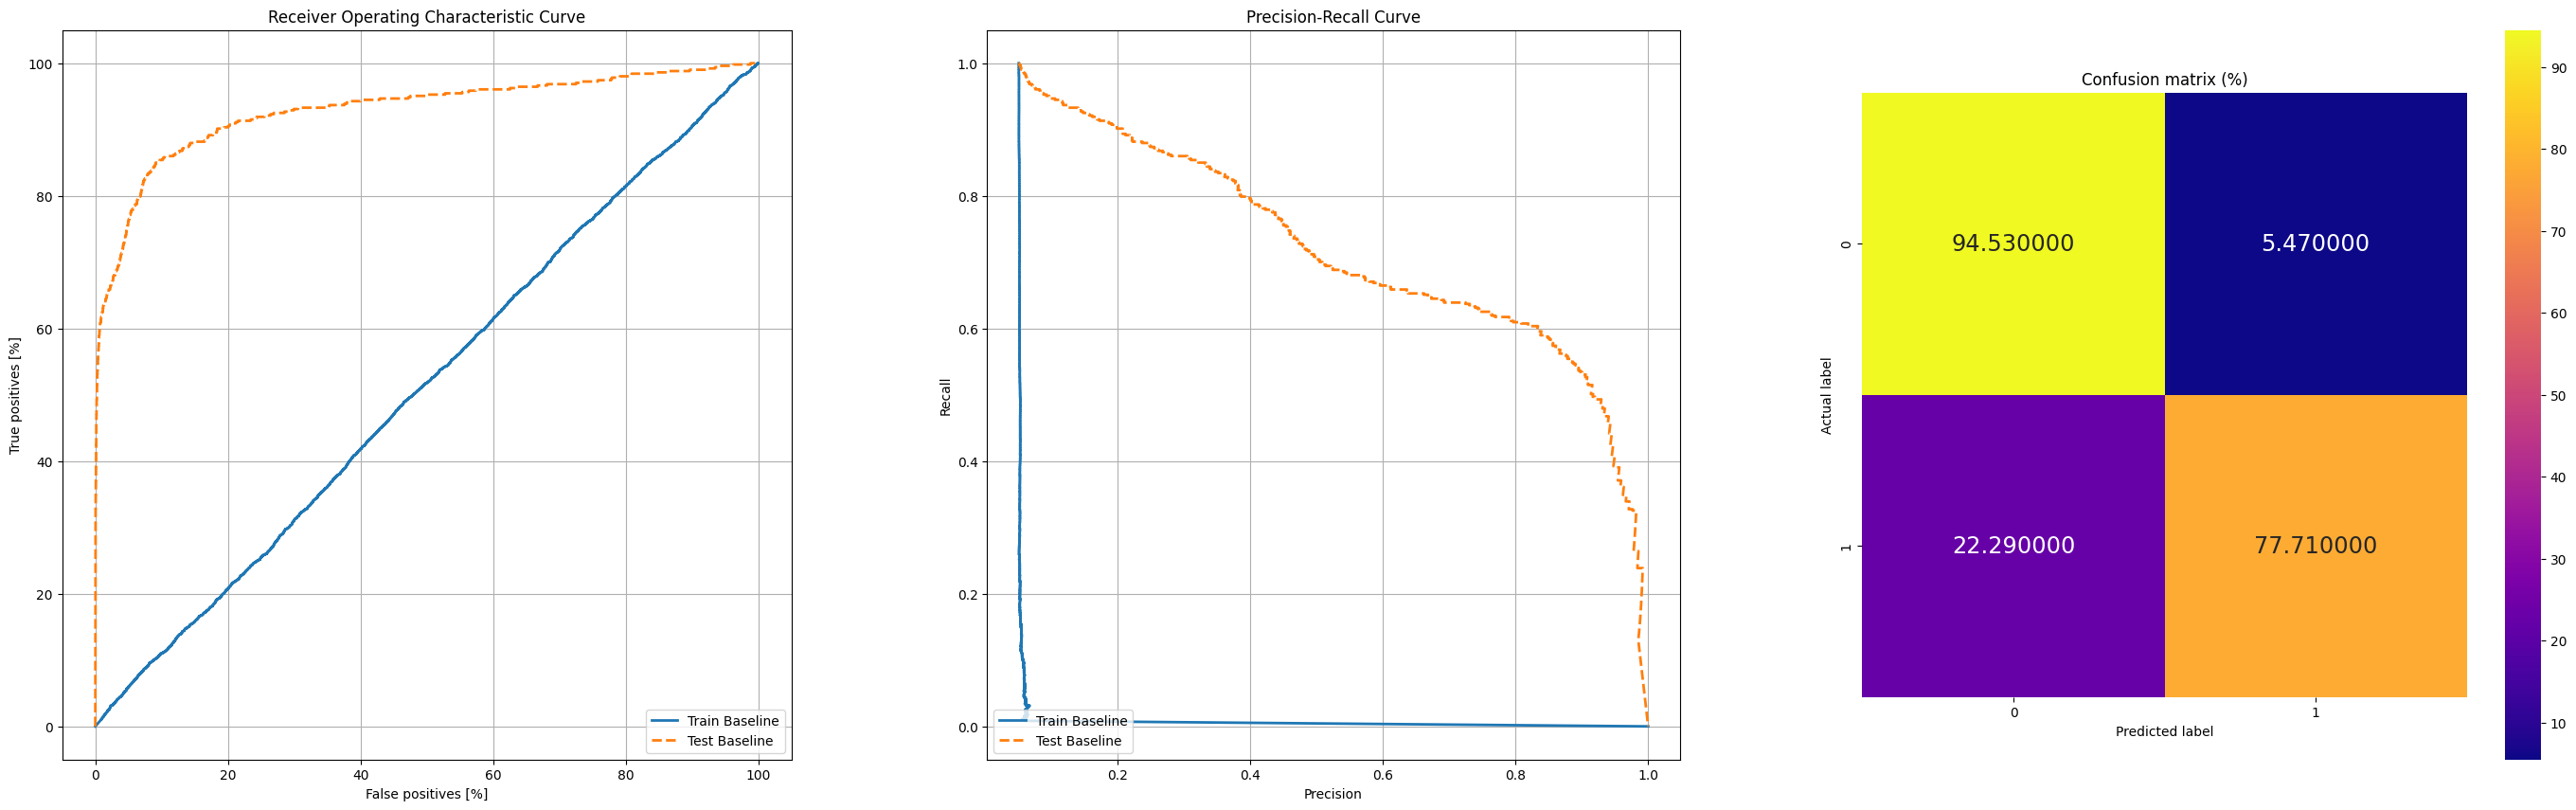

In [19]:
mpl.rcParams['figure.figsize'] = (35, 10)


plt.subplot(1, 3, 1)
plt.title('Receiver Operating Characteristic Curve')
train_fpr_weighted, train_tpr_weighted, train_roc_thresholds_weighted = plot_roc(
    "Train Baseline", train_labels_bl, train_predictions_weighted, color=colors[0])
test_fpr_weighted, test_tpr_weighted, test_roc_thresholds_weighted = plot_roc(
    "Test Baseline", test_labels_bl, test_predictions_weighted, color=colors[1], linestyle='--')
plt.legend(loc='lower right')


plt.subplot(1, 3, 2)
plt.title('Precision-Recall Curve')
plot_prc("Train Baseline", train_labels_bl,
         train_predictions_weighted, color=colors[0])
plot_prc("Test Baseline", test_labels_bl,
         test_predictions_weighted, color=colors[1], linestyle='--')
plt.legend(loc='lower left')

plt.subplot(1, 3, 3)
plot_cm(test_labels_bl, test_predictions_weighted_bool, 'plasma')

for name, value in zip(model.metrics_names, weighted_results):
    if name == 'tp':
        tp = value
    elif name == 'fp':
        fp = value
    elif name == 'tn':
        tn = value
    elif name == 'fn':
        fn = value

    print(f'{name} : {value:.2f}')

# cm = (confusion_matrix(test_labels_bl, test_predictions_baseline, normalize='true')*100)
# cm.round(2)

In [20]:
# filepath_saved_model = '/Users/jonathansullivan/repos/neo-tracklet-classifier/machine-learning/higgs/saved_models'
# higgs_saved_model = higgs_model
# higgs_saved_model.save(filepath_saved_model)

# filepath_saved_model = '/Users/jonathansullivan/repos/neo-tracklet-classifier/machine-learning/higgs/saved_models'
# higgs_model = tf.keras.models.load_model(filepath_saved_model)
# higgs_model.summary()

: 